## Problem Statement

We have been given a PDE: du/dx=2du/dt+u
and boundary condition: u(x,0)=6e^(-3x)

- Independent variables: x,t (input)
- Dependent variables: u (outputs)


We have to find out u(x,t) for all x in range [0,2] and t in range [0,1]


When we solved this problem analytically, we found the solution: u(x,t) = 6e^(-3x-2t)


Our f is f = du/dx - 2du/dt - u

In [5]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

In [6]:
import os
import numpy as np


In [7]:
# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 2 (x,t)
and #outputs = 1

You can add ass many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 5 hidden layer with 5 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def __call__(self, x,t):
        inputs = mx.concatenate([x,t],axis=1)
        layer1_out = mx.sigmoid(self.hidden_layer1(inputs))
        layer2_out = mx.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = mx.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = mx.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = mx.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

In [8]:
### (2) Model
model = Net()
if os.path.isfile("pinn.safetensors"):
    model.load_weights("pinn.safetensors")

mx.eval(model.parameters())

lr_schedule = optim.exponential_decay(1e-1, 0.9)
optimizer = optim.Adam(learning_rate=lr_schedule)

In [9]:
def unet(x,t):
    u = model(x,t)
    return u.sum()

## PDE as loss function. Thus would use the network which we call as u_theta
def theta_pde(x,t):
    # u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = du/dx - 2du/dt - u, we need du/dx and du/dt

    unet_grad_fn = mx.value_and_grad(unet)
    u, grads = unet_grad_fn(x, t)

    # u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t

    u_x = grads[0]
    u_t = grads[1]
    pde = u_x - mx.multiply(2, u_t) - u
    return pde

In [10]:
## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc)

# collocation points
x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
all_zeros = np.zeros((500,1))
all_ones = np.ones((500,1))

In [11]:
def pinn_loss(model, x_bc, t_bc, u_bc, x_collocation, t_collocation):
    # Loss based on boundary conditions
    pt_x_bc = mx.array(x_bc)
    pt_t_bc = mx.array(t_bc)
    pt_u_bc = mx.array(u_bc)
    
    net_bc_out = model(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = nn.losses.mse_loss(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    pt_x_collocation = mx.array(x_collocation)
    pt_t_collocation = mx.array(t_collocation)
    pt_all_zeros = mx.array(all_zeros)
    pt_all_ones = mx.array(all_ones)

    # u = model(pt_x_collocation, pt_t_collocation) # the dependent variable u is given by the network based on independent variables x,t
    f_out = theta_pde(pt_x_collocation, pt_t_collocation) # output of f(x,t)
    f_out = f_out * pt_all_ones
    # loss_and_grad = nn.value_and_grad(mlp, l2_loss)
    # f_out = f(pt_x_collocation, pt_t_collocation, model) # output of f(x,t)
    mse_f = nn.losses.mse_loss(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f
    return loss

In [12]:
loss_and_grad_fn = nn.value_and_grad(model, pinn_loss)


### (3) Training / Fitting
iterations = 1000
previous_validation_loss = 99999999.0
loss_values = []

for epoch in range(iterations):
    # Loss based on boundary conditions
    pt_x_bc = mx.array(x_bc)
    pt_t_bc = mx.array(t_bc)
    pt_u_bc = mx.array(u_bc)
    
    # Loss based on PDE
    pt_x_collocation = mx.array(x_collocation)
    pt_t_collocation = mx.array(t_collocation)
    pt_all_zeros = mx.array(all_zeros)

    loss, grads = loss_and_grad_fn(model, pt_x_bc, pt_t_bc, pt_u_bc, pt_x_collocation, pt_t_collocation)

    # Update the optimizer state and model parameters
    # in a single call
    optimizer.update(model, grads)

    # Force a graph evaluation
    mx.eval(model.parameters(), optimizer.state)

    loss_values.append(loss.tolist())

    if epoch % 50==0:
        print(f"Epoch {epoch}: Loss {loss}")
        model.save_weights("pinn.safetensors")

Epoch 0: Loss array(19.4376, dtype=float32)
Epoch 50: Loss array(24.4813, dtype=float32)
Epoch 100: Loss array(13.3955, dtype=float32)
Epoch 150: Loss array(13.3651, dtype=float32)
Epoch 200: Loss array(13.3649, dtype=float32)
Epoch 250: Loss array(13.3649, dtype=float32)
Epoch 300: Loss array(13.3649, dtype=float32)
Epoch 350: Loss array(13.3649, dtype=float32)
Epoch 400: Loss array(13.3649, dtype=float32)
Epoch 450: Loss array(13.3649, dtype=float32)
Epoch 500: Loss array(13.3649, dtype=float32)
Epoch 550: Loss array(13.3649, dtype=float32)
Epoch 600: Loss array(13.3649, dtype=float32)
Epoch 650: Loss array(13.3649, dtype=float32)
Epoch 700: Loss array(13.3649, dtype=float32)
Epoch 750: Loss array(13.3649, dtype=float32)
Epoch 800: Loss array(13.3649, dtype=float32)
Epoch 850: Loss array(13.3649, dtype=float32)
Epoch 900: Loss array(13.3649, dtype=float32)
Epoch 950: Loss array(13.3649, dtype=float32)


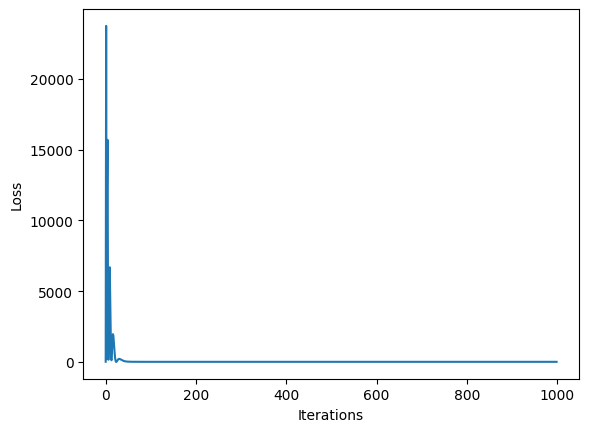

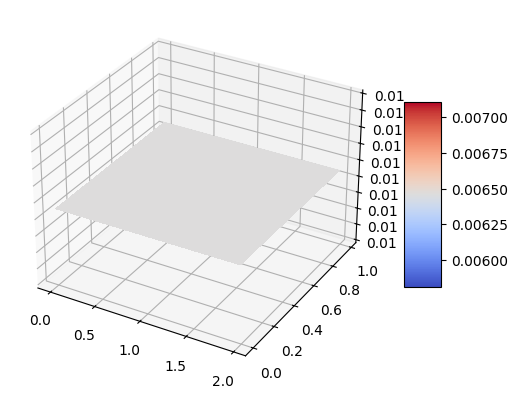

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

losses_numpy = np.array(loss_values, copy=False)
plt.plot(losses_numpy)
plt.xlabel('Iterations')
plt.ylabel('Loss')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = mx.array(x)
pt_t = mx.array(t)
pt_u = model(pt_x,pt_t)
ms_u = pt_u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [14]:
# Save Model
torch.save(net.state_dict(), "model_uxt.pt")

NameError: name 'torch' is not defined